# Analysis of Elevation Profiles of Hiking Trails

## Introduction 
This project focuses on the analysis of elevation profiles of hiking trails. The data sources used are hiking trails from [OpenStreetMap (OSM)](https://www.openstreetmap.org) and elevation data from the [DMR 5G](https://ags.cuzk.cz/arcgis/rest/services/3D/dmr5g/ImageServer) obtained from the [Czech Office for Surveying, Mapping and Cadastre (ČÚZK)](https://cuzk.cz). The project primarily focuses on hiking trails marked by the [Czech Tourist Club (KČT)](https://www.kct.cz).


## Import of libraries
#### Import standard libraries
[os](https://docs.python.org/3/library/os.html)  
[warnings](https://docs.python.org/3/library/warnings.html)  

#### Import libraries for data and geospatial data processing
[requests](https://docs.python-requests.org/en/latest/)  
[geopandas](https://geopandas.org/)  
[rasterio](https://rasterio.readthedocs.io/en/latest/)  
[shapely](https://shapely.readthedocs.io/en/stable/)  

#### Import libraries for visualization
[matplotlib](https://matplotlib.org/)  

#### Import libraries for working with OSM data
[osmapi](https://osmapi.tilmannr.de/)


In [1]:
# Import standard libraries
import os
import warnings

import numpy as np

# Import libraries for data and geospatial data processing
import requests
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, LineString, Polygon
import folium

# Import libraries for visualization
import matplotlib.pyplot as plt

# Import libraries for working with OSM data
import osmapi

The hiking trail relation is downloaded using [OsmApi](https://osmapi.tilmannr.de/). A complete overview of hiking trail numbers in the Czech Republic is available [here](https://osm.paws.cz/hiking.php).

In [2]:
# Function to download a relation by its ID
def download_relation(relation_id):
    try:
        with osmapi.OsmApi() as api:
            return api.RelationGet(relation_id)
    except osmapi.errors.ElementDeletedApiError:
        print(f"Relation with ID {relation_id} has been deleted.")
        return None

Example Usage

In [3]:
# Example ID
relation_id = 334313
relation = download_relation(relation_id)
print(relation)

{'id': 334313, 'visible': True, 'version': 48, 'changeset': 159671790, 'timestamp': datetime.datetime(2024, 11, 27, 18, 14, 37), 'user': 'sannorra', 'uid': 1424365, 'tag': {'complete': 'yes', 'educational': 'yes', 'kct_yellow': 'major', 'name': 'Sigmondova okružní naučná stezka', 'network': 'lwn', 'note': 'Značena žlutým pásovým značením', 'official_name': 'Sigmondova okružní NS', 'operator': 'cz:KČT', 'osmc:symbol': 'yellow:white:yellow_bar', 'ref': '6711', 'route': 'hiking', 'type': 'route'}, 'member': [{'type': 'node', 'ref': 364493953, 'role': 'guidepost'}, {'type': 'node', 'ref': 676243685, 'role': 'guidepost'}, {'type': 'node', 'ref': 676475796, 'role': 'guidepost'}, {'type': 'node', 'ref': 655359905, 'role': 'guidepost'}, {'type': 'node', 'ref': 806808290, 'role': 'guidepost'}, {'type': 'node', 'ref': 2205940692, 'role': 'board'}, {'type': 'node', 'ref': 2205940676, 'role': 'board'}, {'type': 'node', 'ref': 676243685, 'role': 'guidepost'}, {'type': 'node', 'ref': 7099707271, 'ro

In [4]:
# Function to extract descriptive route information from a relation
def extract_route_info(relation):
    tags = relation.get('tag', {})
    route_info = {
        'id': relation['id'],
        'name': tags.get('name', 'Name not provided'),
        'official_name': tags.get('official_name', 'Official name not provided'),
        'route_type': tags.get('route', 'Unknown route type'),
        'operator': tags.get('operator', 'Operator not provided'),
        'symbol': tags.get('osmc:symbol', 'Symbol not provided'),
        'ref': tags.get('ref', 'Reference not provided'),
        'complete': tags.get('complete', 'Not specified'),
        'educational': tags.get('educational', 'Not specified'),
        'network': tags.get('network', 'Unknown network'),
        'kct_yellow': tags.get('kct_yellow', 'Not specified'),
        'note': tags.get('note', 'No note provided'),
    }
    return route_info

In [5]:
# Extract descriptive path information
route_info = extract_route_info(relation)

# Print descriptive path information
print("Descriptive information about the path:")
for key, value in route_info.items():
    print(f"{key}: {value}")

Descriptive information about the path:
id: 334313
name: Sigmondova okružní naučná stezka
official_name: Sigmondova okružní NS
route_type: hiking
operator: cz:KČT
symbol: yellow:white:yellow_bar
ref: 6711
complete: yes
educational: yes
network: lwn
kct_yellow: major
note: Značena žlutým pásovým značením


Function to save relation to geodataframe

In [6]:
def relation_to_geodataframe(relation):
    """
    Converts a relation dictionary into a GeoDataFrame.
    Assumes 'members' contain 'ways' with references to geometry data, and ignores nodes.
    """
    members = relation.get('member', [])
    data = []
    
    for member in members:
        member_type = member.get('type')
        ref = member.get('ref')
        role = member.get('role', '')
        
        if member_type == 'way':
            # Fetch geometry for "way" using the API
            with osmapi.OsmApi() as api:
                way = api.WayGet(ref)
                nodes = way['nd']
                coords = [(api.NodeGet(node_id)['lon'], api.NodeGet(node_id)['lat']) for node_id in nodes]
                geometry = LineString(coords)
                data.append({
                    'type': member_type,
                    'ref': ref,
                    'role': role,
                    'geometry': geometry
                })

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry='geometry')
    return gdf


Example of usage

In [7]:
# Example usage
gdf = relation_to_geodataframe(relation)
display(gdf.head())

,type,ref,role,geometry
0,way,841270075,,"LINESTRING (13.38333 49.78979, 13.38328 49.789..."
1,way,1111089511,,"LINESTRING (13.38315 49.78947, 13.38278 49.789..."
2,way,32399132,,"LINESTRING (13.38224 49.78926, 13.38162 49.789..."
3,way,1111089513,,"LINESTRING (13.38120 49.78914, 13.38107 49.78914)"
4,way,1111089512,,"LINESTRING (13.38107 49.78914, 13.38048 49.78912)"


In [8]:
# Function to determine the trail color from the "osmc:symbol" tag
def get_trail_color(symbol):
    # Examples of mapping the symbol to a color (you can add more symbols as needed)
    if 'yellow' in symbol:
        return 'yellow'
    elif 'red' in symbol:
        return 'red'
    elif 'green' in symbol:
        return 'green'
    elif 'blue' in symbol:
        return 'blue'
    else:
        return 'gray'  # Default color if no match


In [9]:
trail_symbol = route_info.get('symbol')

trail_color = get_trail_color(trail_symbol)

route_name = route_info.get('name', 'No name provided')

In [10]:
import folium

bounds = gdf.total_bounds

center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]

m = folium.Map(location=center, zoom_start=14)

gdf.explore(m=m, tiles="carto positron", color=trail_color)

display(m)

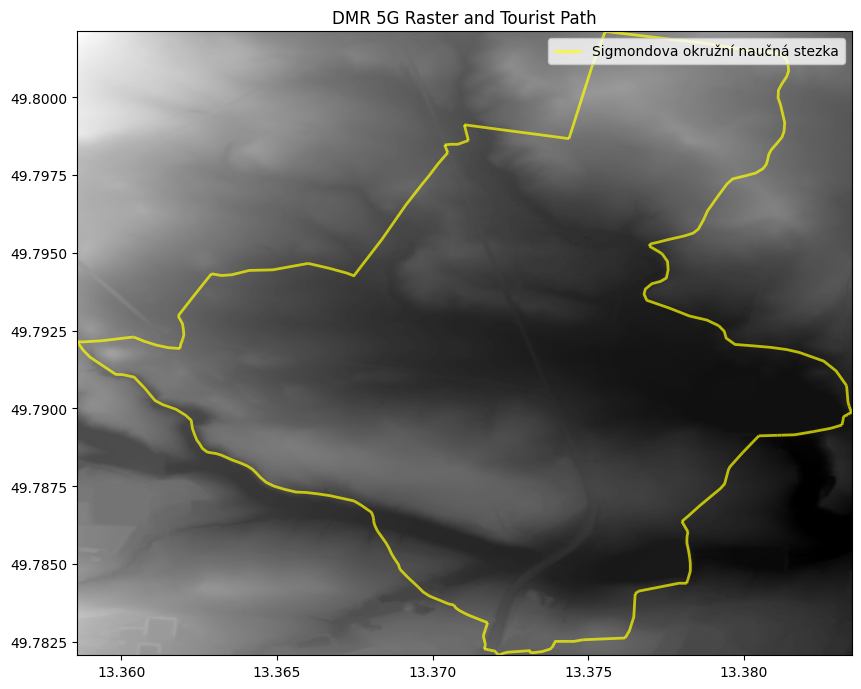

In [11]:
# Getting the bounds of the GeoDataFrame (bounding box)
bbox = gdf.total_bounds  # Returns [minx, miny, maxx, maxy]

# Calculate width and height from the bounding box
minx, miny, maxx, maxy = bbox
width = maxx - minx
height = maxy - miny

max_size = 1200  # Maximum dimension size (for either width or height)

aspect_ratio = width / height

if width > height:
    image_width = max_size
    image_height = int(image_width / aspect_ratio)
else:
    image_height = max_size
    image_width = int(image_height * aspect_ratio)

url = "https://ags.cuzk.cz/arcgis2/rest/services/dmr5g/ImageServer/exportImage"

params = {
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]}",  # Bounding box coordinates (minx, miny, maxx, maxy)
    "bboxSR": 4326,  # Spatial reference for the bounding box (WGS 84)
    "imageSR": 4326,  # Spatial reference for the image (WGS 84)
    "size": f"{image_width},{image_height}",  # Dynamically set image size (in pixels)
    "format": "tiff",  # Output format (TIFF)
    "f": "image"  # Requesting the image (raster data)
}

response = requests.get(url, params=params)

if response.status_code == 200:
    # Save the response content (TIFF file) to a local file
    with open("dmr5g_bounding_box.tif", "wb") as f:
        f.write(response.content)

    #Open the saved TIFF file using rasterio
    with rasterio.open("dmr5g_bounding_box.tif") as src:

        fig, ax = plt.subplots(figsize=(10, 10))
        
        show(src, ax=ax, cmap='gray')
        
        gdf.plot(ax=ax, color=trail_color, alpha=0.7, edgecolor='black', linewidth=2, label=route_name)
        
        # Add a title
        plt.title("DMR 5G Raster and Tourist Path")
        
        # Display the plot
        plt.legend()
        plt.show()

else:
    print(f"Failed to download raster data. Status code: {response.status_code}")

In [12]:
# Assuming 'gdf' is your GeoDataFrame with geographic coordinates (EPSG:4326)
# If the CRS is not set, you can set it using the following command:
gdf_length = gdf.set_crs(epsg=4326, allow_override=True)

# Convert coordinates to a projected coordinate system (metric coordinates)
gdf_length = gdf_length.to_crs(epsg=3395)  # EPSG:3395 is a projected CRS in meters

# Calculate the length in meters
gdf_length['length'] = gdf_length.length

gdf_length = gdf_length.set_crs(epsg=4326, allow_override=True)

# Display the result
print(gdf_length.head())

  type         ref role                                           geometry  \
0  way   841270075       LINESTRING (1489825.83694 6377301.02636, 14898...   
1  way  1111089511       LINESTRING (1489805.16491 6377244.74842, 14897...   
2  way    32399132       LINESTRING (1489704.50983 6377208.82908, 14896...   
3  way  1111089513       LINESTRING (1489588.91567 6377188.62560, 14895...   
4  way  1111089512       LINESTRING (1489574.29942 6377187.95502, 14895...   

       length  
0   64.134991  
1  107.125845  
2  117.978096  
3   14.631624  
4   66.258150  


In [13]:
# Assuming 'gdf' is your GeoDataFrame with geographic coordinates (EPSG:4326)
# Open the raster file (TIFF file) with elevation data
with rasterio.open("dmr5g_bounding_box.tif") as src:
    # Initialize a list to store elevation data
    elevation_data = []

    # Loop through each line in the GeoDataFrame (gdf)
    for line in gdf.geometry:
        # Loop through each coordinate in the line (each point)
        for coord in line.coords:
            lon, lat = coord  # Get longitude and latitude

            # Convert geographic coordinates (lon, lat) to raster row and column indices
            row, col = src.index(lon, lat)

            # Check if the point is within bounds of the raster
            if 0 <= row < src.height and 0 <= col < src.width:
                # Read the elevation value from the raster
                elevation = src.read(1)[row, col]
            else:
                elevation = None  # If the point is out of bounds

            # Append the result (lon, lat, elevation) directly to the list
            elevation_data.append({'lon': lon, 'lat': lat, 'elevation': elevation})

# Create a GeoDataFrame for breakpoints with elevation data
elevation_gdf = gpd.GeoDataFrame(
    elevation_data, 
    geometry=gpd.points_from_xy([d['lon'] for d in elevation_data], [d['lat'] for d in elevation_data]),
    crs="EPSG:4326"  # Set CRS to the original geographic coordinates (WGS84)
)

# Now, calculate the length for the 'gdf' in a projected CRS (EPSG:3395)
gdf_length = gdf.set_crs(epsg=4326, allow_override=True)
gdf_length = gdf_length.to_crs(epsg=3395)  # Convert to projected CRS for correct length calculation
gdf_length['length'] = gdf_length.length  # Calculate the length in meters

# Merge the elevation data with the original gdf
# Assuming the geometry of gdf_length corresponds with gdf
gdf['elevation'] = None  # Create the new column for elevation in the original gdf

# Loop through each line in the original GeoDataFrame (gdf) and assign elevations
for idx, line in gdf.iterrows():
    # Loop through each coordinate in the line
    for coord in line['geometry'].coords:
        lon, lat = coord  # Get longitude and latitude
        # Find the corresponding elevation
        elevation = elevation_gdf[(elevation_gdf['lon'] == lon) & (elevation_gdf['lat'] == lat)]['elevation'].values
        if elevation.size > 0:
            gdf.at[idx, 'elevation'] = elevation[0]  # Assign elevation to the gdf

# Merge the lengths from the gdf_length GeoDataFrame
gdf['length'] = gdf_length['length']

# Display the final GeoDataFrame with elevation and length data
print(gdf[['geometry', 'elevation', 'length']])

                                             geometry   elevation       length
0   LINESTRING (13.38333 49.78979, 13.38328 49.789...  338.308716    64.134991
1   LINESTRING (13.38315 49.78947, 13.38278 49.789...  338.605347   107.125845
2   LINESTRING (13.38224 49.78926, 13.38162 49.789...  338.640015   117.978096
3   LINESTRING (13.38120 49.78914, 13.38107 49.78914)  338.966461    14.631624
4   LINESTRING (13.38107 49.78914, 13.38048 49.78912)  338.412079    66.258150
5   LINESTRING (13.37996 49.78858, 13.38048 49.78912)  338.412079   108.807852
6   LINESTRING (13.37801 49.78637, 13.37821 49.786...  341.787048   445.037461
7   LINESTRING (13.37801 49.78637, 13.37810 49.786...  344.306091    62.684677
8   LINESTRING (13.37820 49.78603, 13.37818 49.785...  342.365662   138.248276
9   LINESTRING (13.37825 49.78523, 13.37826 49.78518)  342.421173     8.897551
10  LINESTRING (13.37826 49.78518, 13.37828 49.785...  342.928314   119.547118
11  LINESTRING (13.37819 49.78449, 13.37816 49.78438

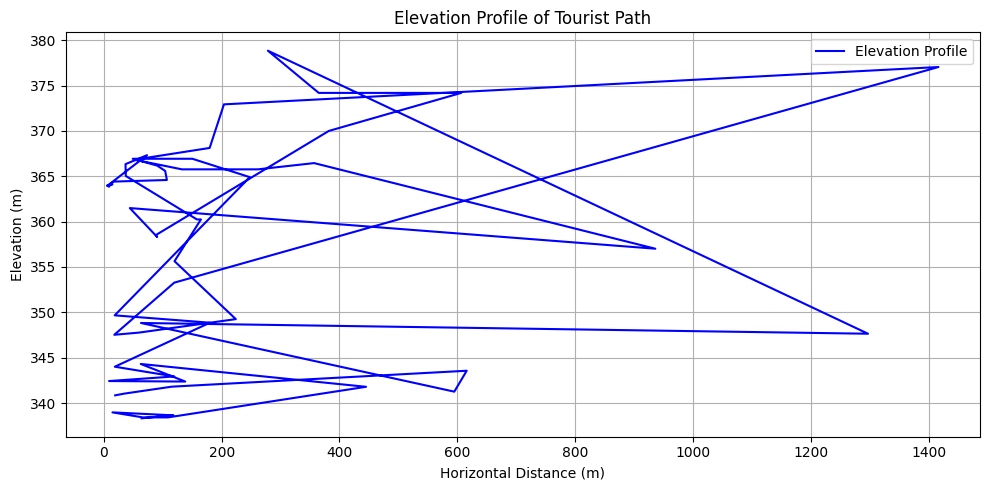

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the data are 1D numpy arrays (in case they are multi-dimensional or pandas series)
elevations = np.array(gdf['elevation'].dropna())  # Convert to numpy array and remove NaN
distances = np.array(gdf['length'].dropna())  # Convert to numpy array and remove NaN

# Check that the length of both arrays is the same
if len(elevations) != len(distances):
    print("The lengths of the elevation and distance arrays do not match!")
else:
    # Plotting the elevation profile
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(distances, elevations, label='Elevation Profile', color='b')

    # Add labels and title
    ax.set_xlabel('Horizontal Distance (m)')
    ax.set_ylabel('Elevation (m)')
    ax.set_title('Elevation Profile of Tourist Path')

    # Show the grid and legend
    ax.grid(True)
    ax.legend()

    # Adjust layout for better display
    plt.tight_layout()

    # Display the plot
    plt.show()


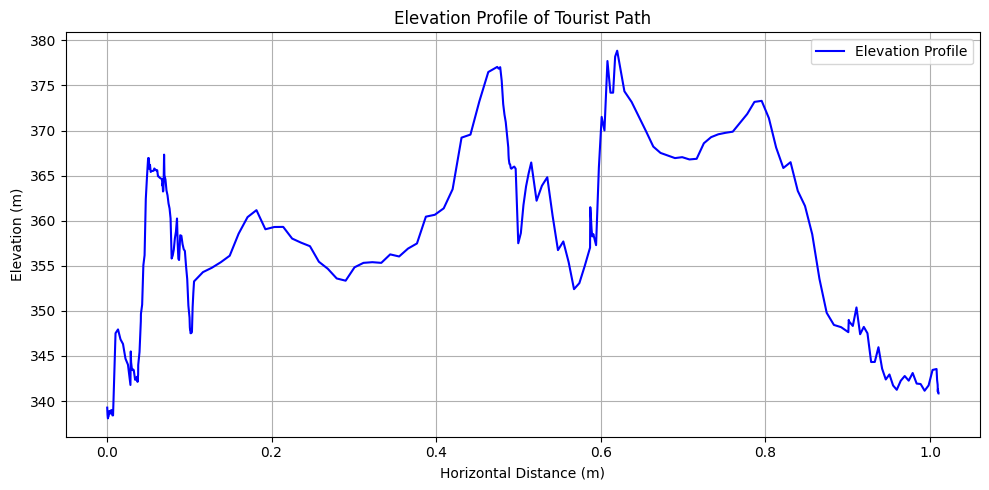

In [48]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import rasterio

# Předpokládáme, že 'gdf' obsahuje geometrii turistických tras a že máte atribut 'distance'

# Vytvoříme seznam pro vzdálenosti a výšky
distances = []
elevations = []

# Kumulativní výpočet vzdálenosti a výšky
cumulative_distance = 0  # Začínáme na nule
for line in gdf.geometry:
    # Pro každou geometrii 'LineString' (jednotlivé turistické trasy)
    coords = list(line.coords)
    for i in range(1, len(coords)):
        # Použijeme hodnoty z 'distance' (nepoužíváme již 'calculate_distance')
        distance = line.length  # Můžete použít 'line.length' pro vzdálenost celé trasy, pokud máte tuto informaci
        cumulative_distance += distance
        distances.append(cumulative_distance)
        
        # Výška (elevation) z rastrového souboru
        lon, lat = coords[i]
        
        # Otevření rastrového souboru a kontrola hranic
        with rasterio.open("dmr5g_bounding_box.tif") as src:
            # Získání řádku a sloupce pro souřadnice
            row, col = src.index(lon, lat)
            
            # Kontrola, zda jsou řádek a sloupec v rámci dostupných dat
            if 0 <= row < src.height and 0 <= col < src.width:
                elevation = src.read(1)[row, col]  # Výška v tomto bodě
                elevations.append(elevation)
            else:
                # Pokud je souřadnice mimo rozsah, přidáme None nebo jiný výchozí znak
                elevations.append(None)

# Ujistíme se, že vzdálenosti a výšky jsou numpy pole pro správné vykreslení
distances = np.array(distances)
elevations = np.array(elevations)

# Vykreslení výškového profilu
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(distances, elevations, label='Elevation Profile', color='b')

# Přidání popisků a titulku
ax.set_xlabel('Horizontal Distance (m)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Elevation Profile of Tourist Path')

# Zobrazení mřížky a legendy
ax.grid(True)
ax.legend()

# Úprava layoutu pro lepší zobrazení
plt.tight_layout()

# Zobrazení grafu
plt.show()
